In [1]:

import pyspark.sql.functions as F
from pyspark.sql.functions import udf, size, avg, count, col,sum, explode
import json
from pyspark.sql.types import *

In [2]:
s3_out_bucket = "s3://mist-test-bucket/wenfeng/df-joined/"
# df_joined.write.parquet(s3_out_bucket)
df_joined = spark.read.parquet(s3_out_bucket)

In [3]:
df_joined.printSchema()

root
 |-- org: string (nullable = true)
 |-- site: string (nullable = true)
 |-- ap: string (nullable = true)
 |-- model: string (nullable = true)
 |-- firmware_version: string (nullable = true)
 |-- terminator_timestamp: long (nullable = true)
 |-- cov_ap: string (nullable = true)
 |-- avg_nclients: double (nullable = true)
 |-- sle_coverage: double (nullable = true)
 |-- coverage_anomaly_score: double (nullable = true)
 |-- coverage_anomaly_count: long (nullable = true)
 |-- ap_sticky: string (nullable = true)
 |-- sticky_count: long (nullable = true)
 |-- ap1: string (nullable = true)
 |-- ap2: string (nullable = true)
 |-- rssi: double (nullable = true)
 |-- ap_2: string (nullable = true)
 |-- coverage_anomaly_count_2: long (nullable = true)



In [4]:
df_joined.count()

3755578

In [5]:
df_joined.show(2)

+--------------------+--------------------+------------+--------+--------------------+--------------------+------+------------+------------+----------------------+----------------------+---------+------------+------------+------------+-----+------------+------------------------+
|                 org|                site|          ap|   model|    firmware_version|terminator_timestamp|cov_ap|avg_nclients|sle_coverage|coverage_anomaly_score|coverage_anomaly_count|ap_sticky|sticky_count|         ap1|         ap2| rssi|        ap_2|coverage_anomaly_count_2|
+--------------------+--------------------+------------+--------+--------------------+--------------------+------+------------+------------+----------------------+----------------------+---------+------------+------------+------------+-----+------------+------------------------+
|bbb101eb-b62d-4fb...|1cb4c485-9dea-4a1...|5c5b350e9ecb|AP41E-US|apfw-0.5.17360-el...|       1598506189801|  null|        null|        null|                  nu

In [6]:
# df_joined = df_joined_new

In [7]:
df_joined_g = df_joined.select("org", "site", "ap", "coverage_anomaly_count", "sticky_count", "ap2", "coverage_anomaly_count_2")\
        .groupBy("org", "site", "ap")\
        .agg( F.avg("coverage_anomaly_count").alias("coverage_anomaly_count"),
              F.countDistinct("ap2").alias("strong_neighbors"),
              F.max("coverage_anomaly_count_2").alias("neighbor_anomaly")
            )

df_joined_g.printSchema()
df_joined_g.show(2)

root
 |-- org: string (nullable = true)
 |-- site: string (nullable = true)
 |-- ap: string (nullable = true)
 |-- coverage_anomaly_count: double (nullable = true)
 |-- strong_neighbors: long (nullable = false)
 |-- neighbor_anomaly: long (nullable = true)

+--------------------+--------------------+------------+----------------------+----------------+----------------+
|                 org|                site|          ap|coverage_anomaly_count|strong_neighbors|neighbor_anomaly|
+--------------------+--------------------+------------+----------------------+----------------+----------------+
|05ecd967-81cf-492...|1e4b4e3c-07f7-4e3...|5c5b355019b9|                  null|               9|            null|
|56de201d-e63b-431...|5e8fe474-a9ee-4d0...|5c5b35bf4f78|                  null|              28|            null|
+--------------------+--------------------+------------+----------------------+----------------+----------------+
only showing top 2 rows



In [8]:
df_joined_g = df_joined_g.filter(F.col("coverage_anomaly_count")>1)#.count()
df_joined_g.count()

6179

In [9]:
df_joined_g.select("org", "site").groupBy("org").count().orderBy("count", ascending=False).show(truncate=False)

+------------------------------------+-----+
|org                                 |count|
+------------------------------------+-----+
|bbb101eb-b62d-4fb1-8c3d-030c6db7e208|2755 |
|604411f1-4e45-4bed-9a69-cc37b247fdf9|508  |
|c1cac1c4-1753-4dde-a065-e17a1c305c2d|362  |
|d8cec22e-e0c2-11e5-8d0f-02e208b2d34f|295  |
|a8c903ae-e6d0-42a7-b815-fe395dea8017|181  |
|9e705fa5-fe73-4723-9cce-848a131f5669|152  |
|a7cc1161-cb41-4e5d-aa41-118a1f06cd12|112  |
|d9ca39f2-a2cd-40af-b095-eecfbeeb8a12|111  |
|20101562-d4f8-41aa-aaa9-98349d78dfa0|110  |
|2eed5700-cb1e-4256-8aa3-73cb580af144|105  |
|f5451dc6-aa80-4d1c-a49a-dede30b6d878|89   |
|3362755c-5ef1-46d8-b541-f576a81f600d|85   |
|0f2adb1c-8843-448f-8753-91a3d2fdbd14|58   |
|39b04356-4cc3-41cc-bc1a-5de54beb1941|48   |
|95c2ff76-5b0a-47b4-a162-de9c4d3c46ba|43   |
|4924c44b-9199-468d-9018-c142e19b485f|40   |
|56de201d-e63b-4312-9858-40f4cfe35c7f|39   |
|2cfa8ba7-0bc5-460b-abd1-babf186740b2|38   |
|22f1cc2d-ea8a-47ea-b4c0-689a86a0bedf|34   |
|af1e02c2-

In [10]:
df_joined_g.select( "site", "ap").groupBy("site").count().orderBy("count", ascending=False).show(truncate=False)

+------------------------------------+-----+
|site                                |count|
+------------------------------------+-----+
|3cf29ebc-21f1-49e5-9956-25495fe8f41b|105  |
|cad89db4-2600-4682-9b22-77c717a213e4|49   |
|8f5a55eb-5d99-4c97-bd26-754acf4f7202|42   |
|64f4d304-5015-4777-911f-d71e809397c2|38   |
|b3c32004-a0dc-4353-b697-1065fbd4f639|36   |
|a799e12a-fc28-4ce7-a563-c2dd6d498e2f|32   |
|8bc13d5c-d055-40ce-8947-56bf5d10eff0|30   |
|5e8fe474-a9ee-4d01-a2b6-b022b0f9c869|25   |
|a860b00f-d96c-4f56-9188-27f5ce050c0f|24   |
|7404fed5-5bee-4564-b594-6e421d123ea7|22   |
|bbcb4791-0591-45d4-bf06-3dd1415d8722|19   |
|d25f5ff6-9d3d-4eed-9254-d1bad8ab848a|18   |
|28a11fdb-7d32-4abc-b8c0-c1eda38b9f92|17   |
|4c65a957-51a1-4c64-ad95-a20f04de3972|15   |
|e0e7ada3-59bb-4189-8e1f-ca489812828c|15   |
|8e3136b2-f3e9-4606-9960-e41c159d129e|14   |
|cd383432-f948-4292-b91f-473689f3c0ba|14   |
|1daacf56-5f45-4afd-a460-0051d15280b8|14   |
|5d5f4381-b859-449b-b055-e20776b65aa7|13   |
|60793c80-

In [11]:
# TODO:  Testing purpose
def coverage_score(nclients, sle_coverage, sle_coverage_anomaly_dev, coverage_anomaly_count):
    """
    AP's coverage score, combining sle_coverage, anomalies and connected clients
    
    :param nclients:
    :param sle_coverage:
    :param sle_coverage_anomaly_dev:
    :param coverage_anomaly_count:
    :return:
    """
    # score = 0.0
    # nclients = nclients or 1.0
    # sle_coverage
    if sle_coverage and nclients and sle_coverage_anomaly_dev and coverage_anomaly_count:
        score = (1.0 - sle_coverage) * \
                sigmoid(nclients - 1.0) * \
                sigmoid(sle_coverage_anomaly_dev - 2.0) * \
                sigmoid(coverage_anomaly_count - 2)
    else:
        score = 0.0
    return float(score)
coverage_score = func.udf(coverage_score, FloatType())



def ap_coverage_severity_score(sle_coverage_anomaly_score,sticky_count, strong_neighbors=0, neighbor_anomaly=None, tx_rx_utl=1.0):
    """
    TODO: to be improved, use the simplied formula for testing.
     Coverage Severity score, combining neighbor's impacting.
    :param sle_coverage_anomaly_score:
    :param strong_neighbors:
    :param neighbor_anomaly:
    :param tx_rx_utl:
    :return:
    """

    score = 0.7 * sle_coverage_anomaly_score

    if neighbor_anomaly and neighbor_anomaly > 0:
        score += 0.3 * neighbor_anomaly
    else:
        if strong_neighbors and strong_neighbors < 1:
            score += 0.2
        else:
            score -= np.log(strong_neighbors)

    score = score * tx_rx_utl
    return float(score)

ap_coverage_severity_score = func.udf(ap_coverage_severity_score, FloatType())




def ap_coverage_score(sle_coverage_anomaly_score, strong_neighbors=0, neighbor_anomaly=None, tx_rx_utl= 1.0):
    score = 0.0
    if sle_coverage_anomaly_score and sle_coverage_anomaly_score>3:
        score = 0.5
    if strong_neighbors and strong_neighbors < 1:
        score += 0.2
    if neighbor_anomaly and neighbor_anomaly > 0:
        score += 0.4
    score = score * tx_rx_utl
    return score

ap_coverage_score = F.udf(ap_coverage_score, FloatType())
df_joined_g = df_joined_g.withColumn("ap_coverage_score", ap_coverage_score(F.col("coverage_anomaly_count"),
                                                                            F.col("strong_neighbors"),
                                                                            F.col("neighbor_anomaly"))
                                     )


df_joined_g.select("ap_coverage_score").describe().show()


+-------+-------------------+
|summary|  ap_coverage_score|
+-------+-------------------+
|  count|               6179|
|   mean| 0.7162809387189436|
| stddev|0.19935234525582432|
|    min|                0.5|
|    max|                0.9|
+-------+-------------------+




* Amazon Sites:  GEG1  Coverage > 90%   =>  expect 0 anomaly 
org_id=56de201d-e63b-4312-9858-40f4cfe3 
site_id=5c7f5e8fe474-a9ee-4d01-a2b6-b022b0f9c869

DXW2

site_id=813724d1-0a77-4898-8d05-7f0e8bdc76ba
org_id=d8cec22e-e0c2-11e5-8d0f-02e208b2d34f


ORG - UPS CAMPUS,    SITE - USNJPRS

https://manage.mist.com/admin/?org_id=d6a1ec7f-a046-4d6b-b7fc-351ec9144d52#!dashboard/serviceLevels/site/09df1500-f1b3-4501-a805-7af21a1fb90f/today/1598857200/1598915607/09df1500-f1b3-4501-a805-7af21a1fb90f

* Sam's club: store 4989,   ==> true-positive 


ORG - TARGET CORPORATION,    SITE - T2456



In [12]:
df_joined_g.select("ap_coverage_score").summary("count", "min", "25%", "50%", "75%", "90%", "max").show()


+-------+-----------------+
|summary|ap_coverage_score|
+-------+-----------------+
|  count|             6179|
|    min|              0.5|
|    25%|              0.5|
|    50%|              0.9|
|    75%|              0.9|
|    90%|              0.9|
|    max|              0.9|
+-------+-----------------+



In [13]:
df_joined_g.select("coverage_anomaly_count", "strong_neighbors", "neighbor_anomaly").summary().show()

+-------+----------------------+-----------------+------------------+
|summary|coverage_anomaly_count| strong_neighbors|  neighbor_anomaly|
+-------+----------------------+-----------------+------------------+
|  count|                  6179|             6179|              3341|
|   mean|     8.774235313157469|10.69072665479851|10.752768632146065|
| stddev|     5.113285406033036|7.592336301448713| 5.518770009902696|
|    min|                   4.0|                0|                 4|
|    25%|                   6.0|                4|                 8|
|    50%|                   8.0|               11|                10|
|    75%|                  11.0|               15|                13|
|    max|                 128.0|               85|               111|
+-------+----------------------+-----------------+------------------+



In [14]:
df_org_sites = df_joined_g.select("org", "site")\
    .groupBy("org").agg(F.countDistinct("site").alias("sites"))\
    .orderBy("sites",ascending=False)
df_org_sites.show()

print("impacting-ORGs {}".format( df_org_sites.count() ))
# df_org_sites.select("sites").summary().show()
df_org_sites.select("sites").summary("count", "min", "50%", "75%", "90%", "95%", "99%", "max").show()

+--------------------+-----+
|                 org|sites|
+--------------------+-----+
|bbb101eb-b62d-4fb...|  848|
|c1cac1c4-1753-4dd...|  312|
|604411f1-4e45-4be...|  271|
|a8c903ae-e6d0-42a...|  179|
|d8cec22e-e0c2-11e...|  176|
|a7cc1161-cb41-4e5...|   96|
|20101562-d4f8-41a...|   92|
|f5451dc6-aa80-4d1...|   83|
|3e22763b-582c-4ea...|   25|
|0f2adb1c-8843-448...|   24|
|22f1cc2d-ea8a-47e...|   20|
|d9ca39f2-a2cd-40a...|   19|
|5a578f3c-f094-4d1...|   19|
|39b04356-4cc3-41c...|   19|
|9e705fa5-fe73-472...|   18|
|7194b7fe-29f2-425...|   17|
|e1bde705-bd39-408...|   13|
|5cc036bb-1f32-4f3...|   13|
|95c2ff76-5b0a-47b...|   12|
|02a5ad6b-c0d2-4cf...|   12|
+--------------------+-----+
only showing top 20 rows

impacting-ORGs 343
+-------+-----+
|summary|sites|
+-------+-----+
|  count|  343|
|    min|    1|
|    50%|    1|
|    75%|    2|
|    90%|    6|
|    95%|   13|
|    99%|  179|
|    max|  848|
+-------+-----+



In [15]:
df_org_sites.select("sites").summary("count", "min", "50%", "75%", "90%", "95%", "99%", "max").show()

+-------+-----+
|summary|sites|
+-------+-----+
|  count|  343|
|    min|    1|
|    50%|    1|
|    75%|    2|
|    90%|    6|
|    95%|   13|
|    99%|  179|
|    max|  848|
+-------+-----+



+------------------------------------+---+
|site                                |aps|
+------------------------------------+---+
|3cf29ebc-21f1-49e5-9956-25495fe8f41b|105|
|cad89db4-2600-4682-9b22-77c717a213e4|49 |
|8f5a55eb-5d99-4c97-bd26-754acf4f7202|42 |
|64f4d304-5015-4777-911f-d71e809397c2|38 |
|b3c32004-a0dc-4353-b697-1065fbd4f639|36 |
|a799e12a-fc28-4ce7-a563-c2dd6d498e2f|32 |
|8bc13d5c-d055-40ce-8947-56bf5d10eff0|30 |
|5e8fe474-a9ee-4d01-a2b6-b022b0f9c869|25 |
|a860b00f-d96c-4f56-9188-27f5ce050c0f|24 |
|7404fed5-5bee-4564-b594-6e421d123ea7|22 |
|bbcb4791-0591-45d4-bf06-3dd1415d8722|19 |
|d25f5ff6-9d3d-4eed-9254-d1bad8ab848a|18 |
|28a11fdb-7d32-4abc-b8c0-c1eda38b9f92|17 |
|4c65a957-51a1-4c64-ad95-a20f04de3972|15 |
|e0e7ada3-59bb-4189-8e1f-ca489812828c|15 |
|8e3136b2-f3e9-4606-9960-e41c159d129e|14 |
|cd383432-f948-4292-b91f-473689f3c0ba|14 |
|1daacf56-5f45-4afd-a460-0051d15280b8|14 |
|5d5f4381-b859-449b-b055-e20776b65aa7|13 |
|60793c80-742a-4cde-8fb2-a230f289ccfd|12 |
+----------

In [17]:
df_site_aps.select("aps").summary("count", "min", "50%", "75%", "90%", "95%", "99%", "max").show()

+-------+----+
|summary| aps|
+-------+----+
|  count|2828|
|    min|   1|
|    50%|   1|
|    75%|   3|
|    90%|   4|
|    95%|   6|
|    99%|  10|
|    max| 105|
+-------+----+



In [ ]:
df_site_aps = df_joined_g.filter("select( "site", "ap").groupBy("site")\
    .agg(F.countDistinct("ap").alias("aps"))\
    .orderBy("aps", ascending=False)

df_site_aps.show(truncate=False)
print("impacting-Sites {}".format( df_site_aps.count() ) )

In [34]:
df_site_aps = df_joined_g.filter(F.col("coverage_anomaly_count")>3).select( "site", "ap").groupBy("site")\
    .agg(F.countDistinct("ap").alias("aps"))\
    .orderBy("aps", ascending=False)

df_site_aps.show(truncate=False)
print("impacting-Sites {}".format( df_site_aps.count() ) )

+------------------------------------+---+
|site                                |aps|
+------------------------------------+---+
|3cf29ebc-21f1-49e5-9956-25495fe8f41b|105|
|cad89db4-2600-4682-9b22-77c717a213e4|49 |
|8f5a55eb-5d99-4c97-bd26-754acf4f7202|42 |
|64f4d304-5015-4777-911f-d71e809397c2|38 |
|b3c32004-a0dc-4353-b697-1065fbd4f639|36 |
|a799e12a-fc28-4ce7-a563-c2dd6d498e2f|32 |
|8bc13d5c-d055-40ce-8947-56bf5d10eff0|30 |
|5e8fe474-a9ee-4d01-a2b6-b022b0f9c869|25 |
|a860b00f-d96c-4f56-9188-27f5ce050c0f|24 |
|7404fed5-5bee-4564-b594-6e421d123ea7|22 |
|bbcb4791-0591-45d4-bf06-3dd1415d8722|19 |
|d25f5ff6-9d3d-4eed-9254-d1bad8ab848a|18 |
|28a11fdb-7d32-4abc-b8c0-c1eda38b9f92|17 |
|4c65a957-51a1-4c64-ad95-a20f04de3972|15 |
|e0e7ada3-59bb-4189-8e1f-ca489812828c|15 |
|8e3136b2-f3e9-4606-9960-e41c159d129e|14 |
|cd383432-f948-4292-b91f-473689f3c0ba|14 |
|1daacf56-5f45-4afd-a460-0051d15280b8|14 |
|5d5f4381-b859-449b-b055-e20776b65aa7|13 |
|60793c80-742a-4cde-8fb2-a230f289ccfd|12 |
+----------

In [18]:
org_id = "604411f1-4e45-4bed-9a69-cc37b247fdf9"
site_id = "a7092875-257f-43f3-9514-ca1ab688bec0" # Sam's club. 4989

#ap403 

df_joined_g.filter(F.col("org")== org_id).show(truncate=False)

df_joined_g.filter(F.col("site")== site_id).show(truncate=False)

+------------------------------------+------------------------------------+------------+----------------------+----------------+----------------+-----------------+
|org                                 |site                                |ap          |coverage_anomaly_count|strong_neighbors|neighbor_anomaly|ap_coverage_score|
+------------------------------------+------------------------------------+------------+----------------------+----------------+----------------+-----------------+
|604411f1-4e45-4bed-9a69-cc37b247fdf9|1b09e83e-495e-4911-9b54-e3197ace36f4|5c5b35bf0711|7.0                   |14              |null            |0.5              |
|604411f1-4e45-4bed-9a69-cc37b247fdf9|5c61a89e-13ba-4d89-bd6c-168cbd3d4e49|5c5b35aef0f5|6.0                   |15              |16              |0.9              |
|604411f1-4e45-4bed-9a69-cc37b247fdf9|0b236c13-45a4-480e-8b0d-6f5031a35faa|5c5b35bf0009|12.0                  |10              |5               |0.9              |
|604411f1-4e45-4

In [19]:
import pandas as pd

In [20]:
df_pd = df_joined_g.toPandas()

In [21]:
df_pd.shape

(6179, 7)

In [22]:
df_joined_g.count()

6179

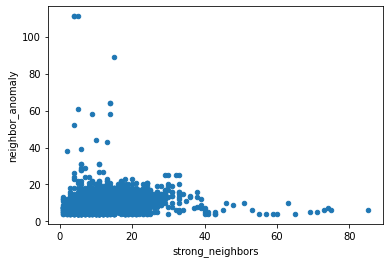

In [23]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

df_pd.plot(kind="scatter", x="strong_neighbors", y="neighbor_anomaly")

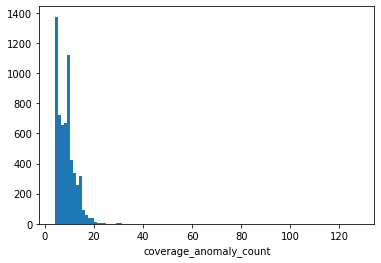

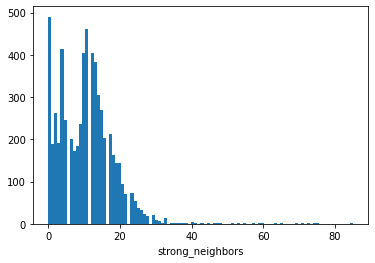

/opt/mistsys/ds_incubator/venv/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/mistsys/ds_incubator/venv/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


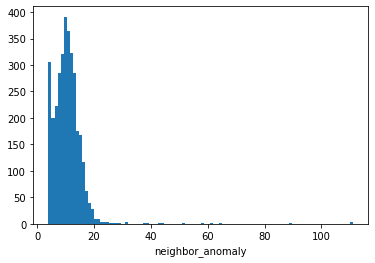

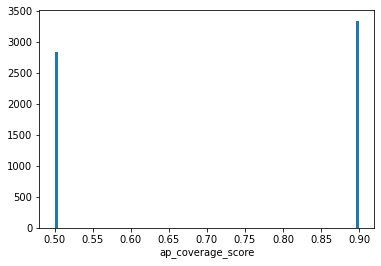

In [24]:
cols = ['coverage_anomaly_count', 'strong_neighbors', 'neighbor_anomaly', 'ap_coverage_score']
for col in cols:
    plt.hist(df_pd[col], bins=100)
    plt.xlabel(col)
    plt.show()
    

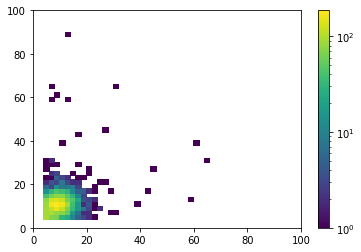

In [25]:
from matplotlib.colors import LogNorm

# df_pd[['coverage_anomaly_count', 'strong_neighbors','neighbor_anomaly']].plot(kind="scatter", subplots=True)
h2 = plt.hist2d(df_pd['coverage_anomaly_count'], df_pd['neighbor_anomaly'], norm=LogNorm(),bins=(50, 50), range=([0,100],[0,100]))
plt.colorbar()
# df_pd = df_pd.fillna(0.0)

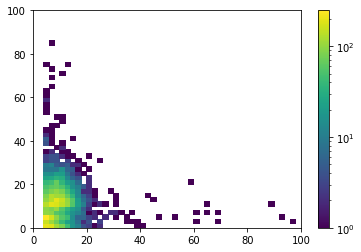

In [26]:
h2 = plt.hist2d(df_pd['coverage_anomaly_count'], df_pd['strong_neighbors'], norm=LogNorm(),bins=(50, 50),  range=([0,100],[0,100]))
plt.colorbar()

In [27]:
df_pd_1 = df_pd[df_pd["coverage_anomaly_count"]>1]
print(df_pd.size, df_pd_1.size)
# h2 = plt.hist2d(df_pd['coverage_anomaly_count'], df_pd['strong_neighbors'], norm=LogNorm(),bins=(50, 50),  range=([0,100],[0,100]))
# plt.colorbar()

43253 43253


In [28]:
# df_pd_g.

In [29]:
df_pd[df_pd['ap_coverage_score']>0.4].shape

(6179, 7)

In [30]:
df_pd.head()

,org,site,ap,coverage_anomaly_count,strong_neighbors,neighbor_anomaly,ap_coverage_score
0,604411f1-4e45-4bed-9a69-cc37b247fdf9,1b09e83e-495e-4911-9b54-e3197ace36f4,5c5b35bf0711,7.0,14,NaN,0.5
1,bbb101eb-b62d-4fb1-8c3d-030c6db7e208,39d7f957-4723-416d-82a4-0ef179830e80,5c5b354e57fd,5.0,22,9.0,0.9
2,f5451dc6-aa80-4d1c-a49a-dede30b6d878,4f34630d-225e-4766-a635-3194b71bf419,5c5b353e0622,7.0,4,NaN,0.5
3,16342635-98c2-4cf7-8798-275f3a7c59b2,9f6e7f61-05f6-4ba4-9574-e3193effabe5,5c5b355074e5,7.0,9,NaN,0.5
4,604411f1-4e45-4bed-9a69-cc37b247fdf9,5c61a89e-13ba-4d89-bd6c-168cbd3d4e49,5c5b35aef0f5,6.0,15,16.0,0.9


In [31]:
6179/185e3

0.0334